In [ ]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder

from sklearn.preprocessing import StandardScaler # Импортируем библиотеку StandardScaler для получения стандартного распределения набора данных
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
import time
import seaborn as sns
sns.set_style('darkgrid')

# LIGHT


## Обработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('Documents/ДЗ/30/online_carts.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/30 Кластеризация/online_carts.csv') # Читаем данные из загруженной базы

In [ ]:
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Посмотрим на уникальные значения каждого из безымянных столбцов
print(df['Unnamed: 0'].unique(),
      df['Unnamed: 2'].unique(),
      df['Unnamed: 3'].unique(),sep='\n')

[nan]
[nan ' Количество(Базовых ед.)' ' ЗаказПокупателя.ID заказа (Элементы)'
 ... '3472' '7616' '2731']
[nan ' Номенклатура.Наименование (Элементы)' 'Количество' 'Базовых ед.'
 '9' '1' '4' '797' '162' '3' '2' '5' '7' '8' '6' '49' '10' '34' '11' '25'
 '20' '13' '17' '29' '1130' '148' '12' '40' '14' '50' '68' '51' '23' '22'
 '16' '1096' '105' '124' '139' '19' '15' '26' '30' '21' '504' '28' '575'
 '60' '61' '18' '80' '942' '44' '188' '24' '1375' '147' '137' '33' '597'
 '82' '37' '860' '47' '825' '27' '45' '229' '887' '113' '58' '104' '38'
 '1751' '134' '138' '1214' '341' '168' '81' '88' '1074' '150' '32' '52'
 '43' '1023' '64' '72' '31' '39' '1237' '254' '46' '289' '1938' '456'
 '132' '2689' '599' '1771' '181' '322' '77' '556' '90' '256' '42' '57'
 '35' '883' '118' '1078' '145' '2749' '36' '1360' '85' '893' '214' '692'
 '119' '1533' '239' '650' '93' '70' '1551' '158' '78' '102' '780' '291'
 '41' '1278' '140' '48' '161' '1127' '122' '94' '978' '98' '769' '92'
 '159' '720' '69' '56' '1648'

In [ ]:
new = df.drop(['Unnamed: 0'], axis =1)                             # Этот столбец не несет никакой информации, так что выкинем его
new.insert(0, column='Дата', value = [x for x in range(len(new))]) # Вставим новую колонку "Дата", чтобы из базы вытащить временные данные в отдельную колонку
new = new.fillna('unknown')                                        # Все Nan заполним строкой "unknown", чтобы не выскакивало ошибок

In [ ]:
new[new['Валовая прибыль'].str.contains("MCOSM")] # MCOSM - флаг начала корзины

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown
...,...,...,...,...,...
99589,99589,MCOSM33527,2714,6,unknown
99596,99596,MCOSM33529,3145,9,unknown
99603,99603,MCOSM33530,3030,12,unknown
99616,99616,MCOSM33537,2259,2,unknown


In [ ]:
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index) # Здесь будут лежать все индексы строк, где есть информация в формате даты

indx=0
for i in range(len(new)):                       # Проходимся по каждой строке базы
  if i in date_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
new

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,Период: Февраль 2019 г. - Август 2019 г.,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,Период: Февраль 2019 г. - Август 2019 г.,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,Период: Февраль 2019 г. - Август 2019 г.,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown,unknown
...,...,...,...,...,...
99627,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
99628,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
99629,02.09.2019 0:00:00,Услуга доставки DPD до двери,350,1,unknown
99630,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Выкинем превьюшные строки
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Выкинем пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Выкинем строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Выкинем ненужную, образовавшуюся после предыдущей операции колонку

In [ ]:
cart_list = list(new[new['Валовая прибыль'].str.contains("MCOSM")].index)        # Здесь будут лежать все индексы строк, где строка содержит флаг начала корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains("CAFRE")].index)       # Здесь будут лежать все индексы строк, где строка содержит флаг CAFRE 

Взглянем на распаршенную базу

In [ ]:
new.head(11)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
5,01.01.2019 0:00:00,XPERT (HS71) машинка для стрижки волос,12989,1,unknown
6,01.01.2019 0:00:00,ЛП ТНА САВАЖ ПАНАШ 250 мл,988,1,unknown
7,01.01.2019 0:00:00,перчатки (50 пар) винил размер S черные,319,1,unknown
8,01.01.2019 0:00:00,Услуга доставки DPD до двери,990,1,unknown
9,01.01.2019 0:00:00,Услуга доставки СДЭК,990,1,unknown


## LIGHT 1.

In [ ]:
# фильтруем записи с доставкой на этапе формирования корзин

carts = []                     # Здесь будут лежать все корзины 
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка

  if i in cart_list:           # Если счетчик в списке индексов-корзин

    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        if 'доставк' not in val[i+1]:
          cart.append(val[i+1])
          allPositions.append(val[i+1]) 
        i+=1 
      
    else:                      # Если же текущий индекс-флаг последний в списке

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен концу списка всех строк в столбце-1
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<(len(new)-1):
        if 'доставк' not in val[i+1]:
          cart.append(val[i+1])
          allPositions.append(val[i+1]) 
        i+=1

    if len(cart) > 0:
      carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину
    
  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем
 


In [ ]:
# проверяем нет ли записей с доставкой
for crt in carts:
  for item in crt:
    if 'доставк' in item.lower():
      print(item)

In [ ]:
# проверяем нет ли записей с доставкой
for i in allPositions:
  if 'доставк' in i.lower():
    print(i)
    

In [ ]:
carts

[['CONTURA (HS61) машинка для стрижки волос',
  'Holika Holika Универсальный гель 99% алоэ вера, 250 мл',
  'Kapous Бальзам-уход для придания объема Volume up 350 мл',
  'Kapous Шампунь для придания объема Volume up 350 мл',
  'XPERT (HS71) машинка для стрижки волос',
  'ЛП ТНА САВАЖ ПАНАШ 250 мл',
  'перчатки (50 пар) винил размер S черные'],
 ['OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл',
  'OLLIN SERVICE LINE Шампунь.-стабилизатор рН 3.5 1000 мл',
  'Масло-уход для светлых волос  ESTEL PRIMA BLONDE 100 мл.',
  '/101 Крем-краска ESTEL PRINCESS ESSEX пепельный',
  '/44 Крем-краска ESTEL PRINCESS ESSEX медный',
  '0/00 Стойкая крем-краска чистый тон',
  '0/00N Крем-краска ESTEL PRINCESS ESSEX нейтральный',
  '0/11 Крем-краска ESTEL PRINCESS ESSEX синий',
  '0/22 Крем-краска ESTEL PRINCESS ESSEX зеленый',
  '0/33 Крем-краска ESTEL PRINCESS ESSEX желтый',
  '0/33 Стойкая крем-краска интенсивный золотистисты',
  '0/55 Крем-краска ESTEL PRINCESS ESSEX красный',
  '0/66 Крем-краска

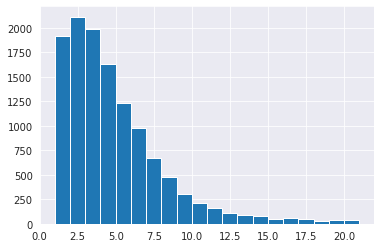

In [ ]:
# Отобразим гистограмму размеров корзин
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

In [ ]:
labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder 
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [ ]:
maxPositionsCount = max(labelEncoder.transform(allPositions))+1 # Посчитаем количество уникальных товаров
print(maxPositionsCount)                                        # Отобразим это количество

6658


In [ ]:
cartsIndexes = [labelEncoder.transform(c) for c in carts] # Создаем список индексов для каждой корзины

In [ ]:
n = 0                  # Укажем номер корзины
print(carts[n])        # Отобразим содержимое этой корзины
print(cartsIndexes[n]) # Отобразим соответствующие индексы

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']
[1503 1732 1804 1987 2962 4226 6269]


In [ ]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированный вектор из 0 и 1
'''
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длинной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса 
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципе Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                     # Создаем пустой список  
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(changeXTo01(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента    
  return np.array(out)                         # Возрващаем сформированную выборку

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) # Создаем выборку по принципу bag of words

In [ ]:
n = 5                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['Бальзам для интенсивного увлажнения волос OTIUM AQUA 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Оттеночный бальзам-уход для холодных светлых оттенков 200 мл.', 'Шампунь для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']
[3138 3323 4860 5820]
[0. 0. 0. ... 0. 0. 0.]


## Кластеризация

*Разбор данного раздела:* https://youtu.be/N4f_BDEYiNA?t=6037

In [ ]:
cur_time = time.time()
clustersCount = 100                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts)                            # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

In [ ]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
clusters_carts = []
for i, s in enumerate(clusterSize):
  print(i, s)
  clusters_carts.append(s)

[ 2 68  2 ... 42  2  2]
0 31
1 23
2 8154
3 116
4 239
5 9
6 1
7 57
8 156
9 1
10 1
11 1
12 177
13 1
14 1
15 1
16 130
17 2
18 70
19 67
20 285
21 1
22 201
23 79
24 1
25 39
26 9
27 1
28 1
29 17
30 173
31 1
32 1
33 1
34 95
35 1
36 1
37 1
38 1
39 1
40 1
41 71
42 395
43 63
44 1
45 1
46 1
47 1
48 1
49 1
50 21
51 29
52 1
53 1
54 1
55 247
56 211
57 105
58 4
59 27
60 1
61 1
62 428
63 47
64 1
65 1
66 48
67 51
68 1
69 154
70 277
71 1
72 1
73 1
74 34
75 1
76 23
77 1
78 109
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 35
90 32
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 37
99 5


In [ ]:
def getCluster(x):
  clasterSize = x.shape[0]                           # Берем размер кластера
  sumX = np.sum(x, axis=0)                           # Считаем сумму кластера по позициям
  sumX /= clasterSize                                # Смотрим насколько часто конкретная позиция появляется в данном кластере
  
  positions = []                                     # Создаем пустой список позиций
  positionValues = []   
  uniq_poss = 0
  
  for i in range(sumX.shape[0]):                     # Пробегаем по всем имеющимся примерам товаров
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      positions.append(position)                     # Добавляем позицию в список позиций 
      positionValues.append(sumX[i])                 # В списк значений добавляем количество данной позиции в текущем кластере
      uniq_poss +=1
  return positions, positionValues, uniq_poss                   # Возвращаем список позиций кластера и количество каждой позиции

In [ ]:
for clusterNumber in range(len(clusterSize)):                # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                       # Если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
    print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
    print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # Преобразуем в numpy
    posVal = np.array(posVal)                                # Преобразуем в numpy
    indexes = posVal > 0.6                                   # Берем индексы тех позиций, доля которых составляет больше 20%
    indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    print()
    print()

Покупок: 8426
Позиций: 5598


Покупок: 33
Позиций: 199
100% ['Сыворотка для секущихся кончиков волос 100 мл.']


Покупок: 142
Позиций: 572
100% ['Шампунь для ежедневного применения 1000 мл. Curex Classic']


Покупок: 50
Позиций: 433
62% ['7/00 Крем-краска ESTEL PRINCESS ESSEX средне-русый для седины']


Покупок: 17
Позиций: 189
100% ['Гель для душа с охлаждающим эффектом ESTEL ALPHA HOMME 250 мл.']
94% ['Тонизирующий шампунь с охлаждающим эффектом для волос ESTEL ALPHA HOMME 250 мл.']


Покупок: 92
Позиций: 768
100% ['Серебристый шампунь для светлых оттенков, 1000 мл']


Покупок: 138
Позиций: 529
100% ['Интенсивная маска для поврежденных волос 500 мл.']


Покупок: 6
Позиций: 32
100% ['Кисть для окрашивания с расческой ESTEL']
100% ['Миска для приготовления окрашивающих смесей ESTEL']
67% ['Эмульсия для удаления краски с волос']
67% ['кисть для окрашивания DEWAL широкая черная']


Покупок: 98
Позиций: 408
88% ['8/61 Тонирующая маска для волос NEWTONE ESTEL Светло-русый фиолетово-пепельн

Готово разбиение на 20 классов
Готово разбиение на 40 классов
Готово разбиение на 60 классов
Готово разбиение на 80 классов
Готово разбиение на 100 классов
Готово разбиение на 120 классов
Готово разбиение на 140 классов
Готово разбиение на 160 классов
Готово разбиение на 180 классов
Готово разбиение на 200 классов
Готово разбиение на 220 классов
Готово разбиение на 240 классов
Готово разбиение на 260 классов
Готово разбиение на 280 классов


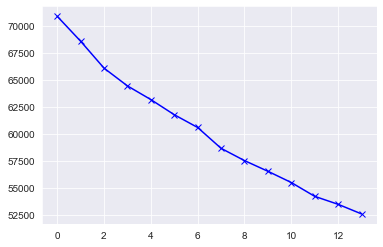

In [ ]:
cost = []
for i in range(1,15):
  kmean = KMeans(i*20)
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i*20, " классов", sep="")
    
plt.plot(cost, 'bx-')

## LIGHT 2.a

Решил вывести гистограммы с разными подходами: первая гистограмма показывает количество по каждому кластеру, а вторая показывает количество кластеров с распределением по количеству уникальных позиций

In [ ]:
clusterSize = np.array(clusterSize)

In [ ]:
labels.shape

(12638,)

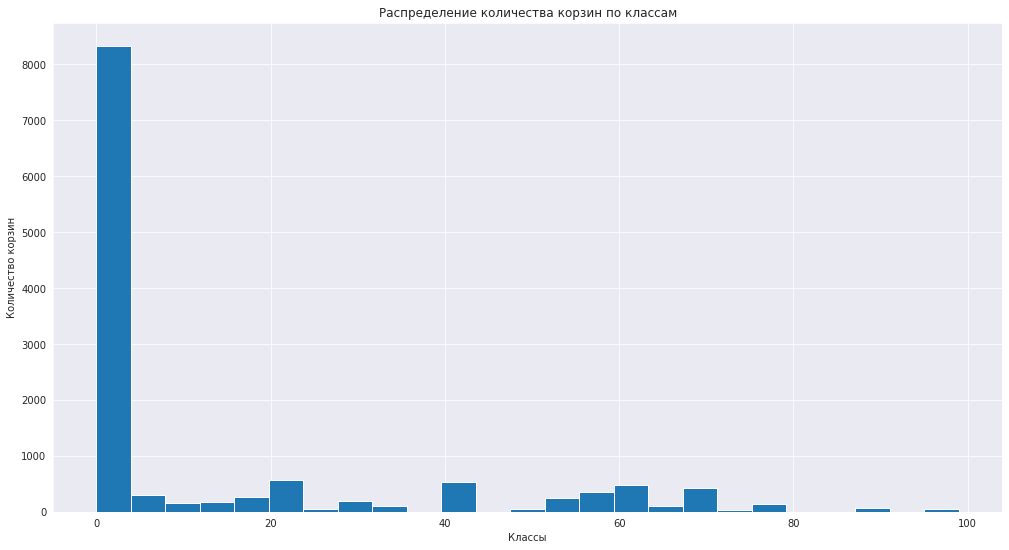

In [ ]:
# гистограмма Распределения размеров классов - сколько корзин
# выведем только самые больше кластеры и отсечем наиболее крупный (для наглядности)
plt.figure(figsize=(17,9))
plt.hist(labels, bins=25)
plt.title('Распределение количества корзин по классам')
plt.xlabel('Классы')
plt.ylabel('Количество корзин')
plt.show()

## LIGHT 2.b

In [ ]:
# гистограмма Распределение количества уникальных позиций в классе

unique_pos_numb = []
for clusterNumber in range(max(labels)):                     # Пробегаем по всем значениям
      pos, posVal, uns = getCluster(carts01[labels==clusterNumber])
      unique_pos_numb.append(uns)


In [ ]:
unique_pos_numb = np.array(unique_pos_numb)

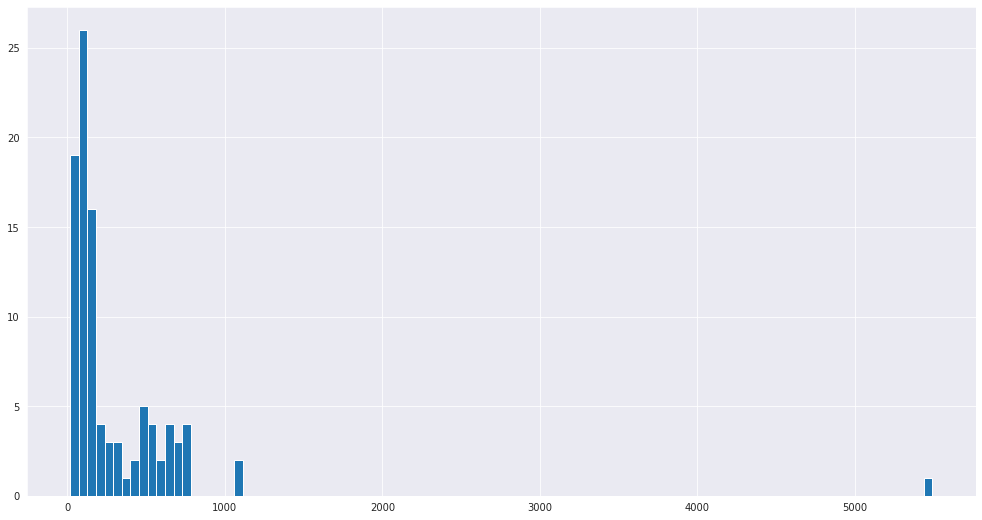

In [ ]:
plt.figure(figsize=(17,9))
plt.hist(unique_pos_numb, bins=100)
plt.title('Распределение количества товаров в классе')
plt.xlabel('Количество уникальных позиций')
plt.ylabel('количество классов')
plt.show()

## LIGHT 3.

In [ ]:
# функция визуализации одного выбранного класса
# -Размер класса
# -Количество уникальных позиций
# -Позиции, которые есть минимум в 20% корзин
# -Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок

def print_clust_info(n_clust):

  cart_num = sum(labels==n_clust)
  pos, posVal  = getCluster(carts01[labels==n_clust])
  pos = np.array(pos)
  posVal = np.array(posVal)

  print('Количество корзин в кластере - ', cart_num)
  print('Уникальных позиций в кластере - ', len(pos))

  indexes = posVal > 0.2                              
  indexedPos = pos[indexes]                              
  indexedPosVal = posVal[indexes]                   

  print()
  print('Позиции, которые есть минимум в 20% корзин: ')
  allWords = {}
  for i in range(len(indexedPos)):
    print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    for w in indexedPos[i][0].split():
      if w in allWords:
        allWords[w] += 1
      else:
        allWords[w] = 1
  print()
  print('Уникальные слова, которые встречаются минимум в 20% позиций:')
  for wrd, cnt in allWords.items():
    if cnt / len(pos) > 0.2:
      print((cnt / len(pos)*100,'% ', wrd))

In [ ]:
print_clust_info(1)

Количество корзин в кластере -  2
Уникальных позиций в кластере -  151

Позиции, которые есть минимум в 20% корзин: 
50% ['0/00 Стойкая крем-краска чистый тон']
50% ['0/66 Крем-краска ESTEL PRINCESS ESSEX фиолетовый']
50% ['10/0 Крем-краска ESTEL PRINCESS ESSEX светлый блондин']
50% ['10/0 Стойкая крем-краска яркий блонд']
50% ['10/1 Крем-краска ESTEL PRINCESS ESSEX светлый блондин пепельный']
50% ['10/69 яркий блонд фиолетовый сандре Illumina Color']
50% ['10/81 яркий блонд перламутрово-пепельный Интенсивное тонирование НОВЫЙ']
50% ['12/61 Стойкая крем-краска специальный блонд фиолет']
50% ['12/96 Стойкая крем-краска специальный блонд сандрэ фиолетовый']
50% ['4/ коричневый Illumina Color']
50% ['4/6 Крем-краска ESTEL PRINCESS ESSEX баклажан']
50% ['4/7 Крем-краска ESTEL PRINCESS ESSEX мокко']
50% ['5.8 HY светлый коричневый шоколад 100 мл']
50% ['5/6 Крем-краска ESTEL PRINCESS ESSEX божоле']
50% ['5/66 светлый шатен интенсивно-фиолетовый Интенсивное тонирование НОВЫЙ']
50% ['5/7 Крем

# PRO1

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SpatialDropout1D, Embedding, Flatten, Activation, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow
import time
from sklearn.cluster import KMeans 
!pip install pymorphy2
import pymorphy2
!pip install pymorphy2-dicts-ru
!pip install pymorphy2-dicts

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Подготовка данных

In [ ]:
# Для загрузки в удаленную среду
def readText(fileName):
  f = open(fileName, 'r', encoding='utf-8')
  text = f.read()
  text = text.replace('\n', ' ')
  return text
className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nClasses = len(className)

In [ ]:
#  для загрузки с локальной среды
def readText(fileName):
  f = open(fileName, 'r', encoding='utf-8')
  text = f.read()
  text = text.replace('\n', ' ')
  return text
className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nClasses = len(className)

In [ ]:
#  для загрузки с локальной среды
trainText = []
testText = []

for i in className:
  for j in os.listdir('Documents/ДЗ/30/Писатели'):
    if i in j:
      if 'Обучающая' in j:
        trainText.append(readText('Documents/ДЗ/30/Писатели/'+j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('Documents/ДЗ/30/Писатели/'+j))
        print(j, 'добавлен в тестовую выборку')


(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку


In [ ]:
# Для загрузки в удаленную среду
trainText = []
testText = []

for i in className:
  for j in os.listdir('/content/drive/My Drive/Colab Notebooks/17 Обработка текстов/Писатели/'):
    if i in j:
      if 'Обучающая' in j:
        trainText.append(readText('/content/drive/My Drive/Colab Notebooks/17 Обработка текстов/Писатели/'+j))
        print(j, 'добавлен в обучающую выборку')
      if 'Тестовая' in j:
        testText.append(readText('/content/drive/My Drive/Colab Notebooks/17 Обработка текстов/Писатели/'+j))
        print(j, 'добавлен в тестовую выборку')


(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку


In [ ]:
# для формирования выборок для обучения нейронки
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index +=step
  return xSample

In [ ]:
# для формирования выборок для обучения нейронки
def createSetMultiClasses(wordIndexes, xLen, step):
  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))
  
  xSamples = []
  ySamples = []

  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)):
      xSamples.append(xT[i])
      ySamples.append(utils.to_categorical(t, nClasses))

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  return (xSamples, ySamples)

In [ ]:
# задаем параметры токенайзера и выборки для нейронки
# после нескольких экспримернтов решил токенизировать весь словарь
tokenizer = Tokenizer(filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)
xLen = 500
step = 50

xTrain, yTrain = createSetMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetMultiClasses(testWordIndexes, xLen, step)


In [ ]:
all_shape = np.fromiter(tokenizer.word_index.keys(), dtype='U25').shape[0]  # узнаем количество уникальных слов в словаре

In [ ]:
# формируем текст с меньшим регистром (для формирования setов уникальных слов)
trainText_low = []
testText_low = []
for i in range(len(className)):
  trainText_low.append(list(map(str.lower, trainText[i].split())))
  testText_low.append(list(map(str.lower, testText[i].split())))

## Embeddin 50

Epoch 1/25
553/553 [==============================] - 42s 72ms/step - loss: 0.7767 - accuracy: 0.7181 - val_loss: 0.6157 - val_accuracy: 0.7936
Epoch 2/25
553/553 [==============================] - 40s 72ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.5820 - val_accuracy: 0.7985
Epoch 3/25
553/553 [==============================] - 39s 71ms/step - loss: 6.4429e-04 - accuracy: 1.0000 - val_loss: 0.5639 - val_accuracy: 0.8035
Epoch 4/25
553/553 [==============================] - 39s 70ms/step - loss: 3.0940e-04 - accuracy: 1.0000 - val_loss: 0.5510 - val_accuracy: 0.8073
Epoch 5/25
553/553 [==============================] - 39s 71ms/step - loss: 1.7580e-04 - accuracy: 1.0000 - val_loss: 0.5398 - val_accuracy: 0.8105
Epoch 6/25
553/553 [==============================] - 39s 70ms/step - loss: 1.0872e-04 - accuracy: 1.0000 - val_loss: 0.5373 - val_accuracy: 0.8099
Epoch 7/25
553/553 [==============================] - 39s 70ms/step - loss: 7.0420e-05 - accuracy: 1.0000 - val_loss: 0.

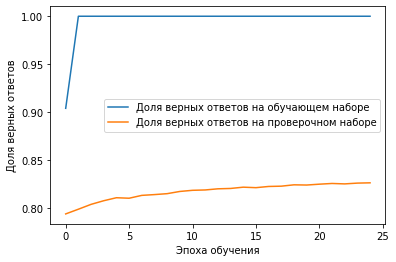

In [ ]:
# пишем нейронку. После нескольких вариантов проб, пришел к выводу что для текущей задачи подходит максимально простая нейронка
inputs = Input(shape=(xLen))
emb = Embedding(all_shape+1, 50)(inputs)

x = Flatten()(emb)
fin = Dense(6, activation='sigmoid')(x)

modelE = Model(inputs, fin)

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=25,
                    batch_size=64,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
modelE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           6653550   
_________________________________________________________________
flatten (Flatten)            (None, 25000)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 150006    
Total params: 6,803,556
Trainable params: 6,803,556
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# сохраняем отдельную модель только с эмбеддингом
modelEmb = Model(inputs, emb)
modelEmb.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           6653550   
Total params: 6,653,550
Trainable params: 6,653,550
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelEmb.save('Documents/ДЗ/30/modelEmb.h5')

In [ ]:
modelEmb.save('/content/drive/MyDrive/Colab Notebooks/30 Кластеризация /modelEmb.h5')

In [ ]:
from tensorflow.keras.models import load_model
modelEmb = load_model('Documents/ДЗ/30/modelEmb.h5')

In [ ]:
from tensorflow.keras.models import load_model
modelEmb = load_model('/content/drive/MyDrive/Colab Notebooks/30 Кластеризация /modelEmb.h5')

In [ ]:
space = np.linspace(0,all_shape-1,all_shape).astype(int)   # формируем пространство индексов всех слов всего словаря для подачи в ембеддинг слой

In [ ]:
# подаем индексы словаря в ембеддинг слой, разбивая по "окнам"/ Результат сохраняем в массив
pred_all = np.squeeze(modelEmb.predict(np.expand_dims(space[:xLen], axis=0)))
n = 1
for i in range(xLen,all_shape-xLen-1, xLen):
  batch = np.expand_dims(space[i:i+xLen], axis=0)
  pred_all = np.vstack((pred_all, np.squeeze(modelEmb.predict(batch))))
  n +=1

### 6 кластеров

In [ ]:
# кластеризуем поргнанные через эмбеддинг слова
cur_time = time.time()
clustersCount = 6                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  7.6 c


In [ ]:
# анализируем полученные классы на предмет вхождения в них слов, которые больше или меньше используются разными авторами
# по каждому кластеру выводитсся:
# - номер
# - каким автором больше исполбзуются слова в данному кластере
# - разбивка количества слов в кластере по авторам. В списке количество слов, которые пересекаются в кластере и у автора и процент этого пересечения
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])  # получаем уникальные слова кластера из токенайзера
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0      # составляем словарь по авторам с нулевыми счетчиками
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])    # получаем уникальные слова автора

    res_list.append(len(uniq_words_clust & uniq_words_class))    # количество уникальных пересекающихся слов автора и кластера
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))    # процент слов кластера, который используется у автора
    writers[className[j]] = res_list   # записываем в уникальный словарь
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr      # ищем автора у которого процент использования слов в кластере максимальный
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Стругацкие
{'О. Генри': [3618, 6.2], 'Стругацкие': [17324, 19.15], 'Булгаков': [5540, 6.8], 'Саймак': [3744, 7.44], 'Фрай': [7201, 6.15], 'Брэдберри': [5009, 6.92]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  Саймак
{'О. Генри': [3448, 5.91], 'Стругацкие': [4413, 4.88], 'Булгаков': [4132, 5.07], 'Саймак': [9239, 18.35], 'Фрай': [5863, 5.0], 'Брэдберри': [4296, 5.94]}
---------------------------------------
Кластер  3
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [4165, 7.14], 'Стругацкие': [5828, 6.44], 'Булгаков': [5570, 6.83], 'Саймак': [3950, 7.85], 'Фрай': [20983, 17.91], 'Брэдберри': [5956, 8.23]}
---------------------------------------
Кластер  4
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [14383, 24.65], 'Стругацкие': [4358, 4.82], 'Булгаков': [4266, 5.23], 'Саймак': [2956, 5.87], 'Фрай': [5469, 4.67], 'Брэдберри': [3990, 5.51]}
--------------------------

In [ ]:
morph = pymorphy2.MorphAnalyzer(lang='ru-old')

/usr/local/lib/python3.6/dist-packages/pymorphy2/analyzer.py:296: UserWarning: Dictionary language (None) doesn't match analyzer language ('ru-old').
  "analyzer language (%r)." % (dictionary.lang, lang)


In [ ]:
# проведем морфологический анализ слов в разбивке по кластерам
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,    # части речи
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}   # падежи
  gender = {'masc':0, 'neut':0, 'femn':0}   # род
  numb = {'sing':0, 'plur':0}  # число
  tense = {'past':0, 'pres':0, 'futr':0}   # время
  person = {'2per':0, '3per':0, '1per':0}  # лицо
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])   # получаем уникальные слова кластера
  for wrd in uniq_words_clust:    # получаем теги по каждому уникальному слову. В случае нахождения одного из тега словаря прибавляем к соответствующему тегу единицу
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
   # считаем суммы по каждому тэгу во всех кластерах
  POS_sum = sum(POS.values())  
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  # считаем процент тегов каждого кластера от тэгов всех кластеров
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'    
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.38%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.2%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.16%', 'gent': '0.28%', 'nomn': '0.35%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.52%', 'neut': '0.14%', 'femn': '0.34%'}
{'sing': '0.71%', 'plur': '0.29%'}
{'past': '0.63%', 'pres': '0.27%', 'futr': '0.1%'}
{'2per': '0.2%', '3per': '0.56%', '1per': '0.24%'}
---------------------------------

Кластер  2
{'PRTF': '0.07%', 'GRND': '0.02%', 'NOUN': '0.36%', 'ADVB': '0.02%', 'VERB': '0.25%', 'PRTS': '0.01%', 'ADJF': '0.18%', 'INFN': '0.05%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.01%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nom

### 2 кластера

In [ ]:
cur_time = time.time()
clustersCount = 2                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  5.34 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [6278, 10.76], 'Стругацкие': [8545, 9.45], 'Булгаков': [8367, 10.27], 'Саймак': [6359, 12.63], 'Фрай': [23215, 19.81], 'Брэдберри': [8316, 11.49]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [25739, 44.12], 'Стругацкие': [32101, 35.49], 'Булгаков': [29497, 36.19], 'Саймак': [19579, 38.89], 'Фрай': [27844, 23.76], 'Брэдберри': [24540, 33.9]}
---------------------------------------


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.06%', 'GRND': '0.02%', 'NOUN': '0.38%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.2%', 'INFN': '0.05%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nomn': '0.34%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.08%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.5%', 'neut': '0.15%', 'femn': '0.35%'}
{'sing': '0.73%', 'plur': '0.27%'}
{'past': '0.59%', 'pres': '0.27%', 'futr': '0.14%'}
{'2per': '0.2%', '3per': '0.53%', '1per': '0.27%'}
---------------------------------

Кластер  2
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.39%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.2%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nomn'

### 4 кластера

In [ ]:
cur_time = time.time()
clustersCount = 4                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  6.09 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Стругацкие
{'О. Генри': [4064, 6.97], 'Стругацкие': [17965, 19.86], 'Булгаков': [6015, 7.38], 'Саймак': [4221, 8.38], 'Фрай': [7780, 6.64], 'Брэдберри': [5596, 7.73]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [4636, 7.95], 'Стругацкие': [6336, 7.0], 'Булгаков': [6125, 7.52], 'Саймак': [4512, 8.96], 'Фрай': [21087, 18.0], 'Брэдберри': [6524, 9.01]}
---------------------------------------
Кластер  3
наибольшее слов автора в кластере у  Булгаков
{'О. Генри': [6708, 11.5], 'Стругацкие': [8071, 8.92], 'Булгаков': [17831, 21.88], 'Саймак': [5448, 10.82], 'Фрай': [11131, 9.5], 'Брэдберри': [12636, 17.46]}
---------------------------------------
Кластер  4
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [16609, 28.47], 'Стругацкие': [8274, 9.15], 'Булгаков': [7893, 9.69], 'Саймак': [11757, 23.35], 'Фрай': [11061, 9.44], 'Брэдберри': [8100, 11.19]}
----------------

In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.39%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.19%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.16%', 'gent': '0.28%', 'nomn': '0.35%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.52%', 'neut': '0.15%', 'femn': '0.34%'}
{'sing': '0.71%', 'plur': '0.29%'}
{'past': '0.63%', 'pres': '0.27%', 'futr': '0.1%'}
{'2per': '0.19%', '3per': '0.57%', '1per': '0.24%'}
---------------------------------

Кластер  2
{'PRTF': '0.06%', 'GRND': '0.02%', 'NOUN': '0.37%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.21%', 'INFN': '0.05%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'no

### 12 кластеров

In [ ]:
cur_time = time.time()
clustersCount = 12                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  28.55 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Саймак
{'О. Генри': [2212, 3.79], 'Стругацкие': [2918, 3.23], 'Булгаков': [2765, 3.39], 'Саймак': [5946, 11.81], 'Фрай': [3896, 3.33], 'Брэдберри': [2722, 3.76]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  Булгаков
{'О. Генри': [2177, 3.73], 'Стругацкие': [3267, 3.61], 'Булгаков': [9883, 12.13], 'Саймак': [1837, 3.65], 'Фрай': [3841, 3.28], 'Брэдберри': [2597, 3.59]}
---------------------------------------
Кластер  3
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [1585, 2.72], 'Стругацкие': [2077, 2.3], 'Булгаков': [2143, 2.63], 'Саймак': [1624, 3.23], 'Фрай': [6932, 5.92], 'Брэдберри': [2479, 3.42]}
---------------------------------------
Кластер  4
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [10101, 17.31], 'Стругацкие': [2753, 3.04], 'Булгаков': [2742, 3.36], 'Саймак': [1831, 3.64], 'Фрай': [3520, 3.0], 'Брэдберри': [2482, 3.43]}
------------------------------

In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.02%', 'NOUN': '0.35%', 'ADVB': '0.02%', 'VERB': '0.26%', 'PRTS': '0.01%', 'ADJF': '0.19%', 'INFN': '0.05%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.01%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nomn': '0.34%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.5%', 'neut': '0.17%', 'femn': '0.33%'}
{'sing': '0.7%', 'plur': '0.3%'}
{'past': '0.6%', 'pres': '0.26%', 'futr': '0.14%'}
{'2per': '0.19%', '3per': '0.56%', '1per': '0.25%'}
---------------------------------

Кластер  2
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.4%', 'ADVB': '0.01%', 'VERB': '0.2%', 'PRTS': '0.02%', 'ADJF': '0.21%', 'INFN': '0.03%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.16%', 'gent': '0.28%', 'nomn':

## Embedding 300

Epoch 1/25
553/553 [==============================] - 217s 391ms/step - loss: 0.5453 - accuracy: 0.8087 - val_loss: 0.6742 - val_accuracy: 0.7863
Epoch 2/25
553/553 [==============================] - 216s 391ms/step - loss: 5.8178e-04 - accuracy: 1.0000 - val_loss: 0.6576 - val_accuracy: 0.7885
Epoch 3/25
553/553 [==============================] - 216s 390ms/step - loss: 2.4189e-04 - accuracy: 1.0000 - val_loss: 0.6488 - val_accuracy: 0.7906
Epoch 4/25
553/553 [==============================] - 216s 390ms/step - loss: 1.2417e-04 - accuracy: 1.0000 - val_loss: 0.6412 - val_accuracy: 0.7934
Epoch 5/25
553/553 [==============================] - 214s 388ms/step - loss: 7.3550e-05 - accuracy: 1.0000 - val_loss: 0.6355 - val_accuracy: 0.7949
Epoch 6/25
553/553 [==============================] - 214s 388ms/step - loss: 4.6990e-05 - accuracy: 1.0000 - val_loss: 0.6333 - val_accuracy: 0.7960
Epoch 7/25
553/553 [==============================] - 215s 388ms/step - loss: 3.1427e-05 - accuracy: 1.0

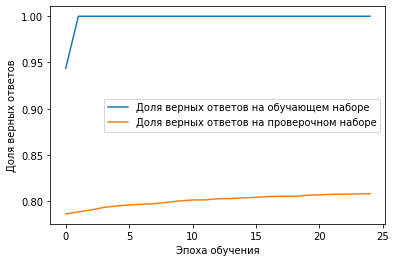

In [ ]:

inputs = Input(shape=(xLen))
emb = Embedding(all_shape+1, 300)(inputs)

x = Flatten()(emb)
fin = Dense(6, activation='sigmoid')(x)

modelE = Model(inputs, fin)

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=25,
                    batch_size=64,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
modelEmb = Model(inputs, emb)

In [ ]:
pred_all = np.squeeze(modelEmb.predict(np.expand_dims(space[:xLen], axis=0)))
n = 1
for i in range(xLen,all_shape-xLen-1, xLen):
  batch = np.expand_dims(space[i:i+xLen], axis=0)
  pred_all = np.vstack((pred_all, np.squeeze(modelEmb.predict(batch))))
  n +=1
  print(n)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


### 6 кластеров

In [ ]:
cur_time = time.time()
clustersCount = 6                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  41.12 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Брэдберри
{'О. Генри': [3276, 5.62], 'Стругацкие': [4529, 5.01], 'Булгаков': [4358, 5.35], 'Саймак': [3096, 6.15], 'Фрай': [5990, 5.11], 'Брэдберри': [9714, 13.42]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  Стругацкие
{'О. Генри': [3472, 5.95], 'Стругацкие': [16881, 18.66], 'Булгаков': [5240, 6.43], 'Саймак': [3565, 7.08], 'Фрай': [6774, 5.78], 'Брэдберри': [4774, 6.6]}
---------------------------------------
Кластер  3
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [14584, 25.0], 'Стругацкие': [4538, 5.02], 'Булгаков': [4455, 5.47], 'Саймак': [3055, 6.07], 'Фрай': [5757, 4.91], 'Брэдберри': [4094, 5.66]}
---------------------------------------
Кластер  4
наибольшее слов автора в кластере у  Саймак
{'О. Генри': [3407, 5.84], 'Стругацкие': [4514, 4.99], 'Булгаков': [4154, 5.1], 'Саймак': [9285, 18.44], 'Фрай': [5961, 5.09], 'Брэдберри': [4326, 5.98]}
-----------------------

In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.02%', 'NOUN': '0.37%', 'ADVB': '0.02%', 'VERB': '0.27%', 'PRTS': '0.01%', 'ADJF': '0.18%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.14%', 'gent': '0.28%', 'nomn': '0.37%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.5%', 'neut': '0.14%', 'femn': '0.36%'}
{'sing': '0.69%', 'plur': '0.31%'}
{'past': '0.6%', 'pres': '0.26%', 'futr': '0.14%'}
{'2per': '0.19%', '3per': '0.58%', '1per': '0.23%'}
---------------------------------

Кластер  2
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.38%', 'ADVB': '0.02%', 'VERB': '0.22%', 'PRTS': '0.01%', 'ADJF': '0.19%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.16%', 'gent': '0.28%', 'nom

### 2 кластера

In [ ]:
cur_time = time.time()
clustersCount = 2                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  29.41 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [25727, 44.1], 'Стругацкие': [32915, 36.39], 'Булгаков': [30466, 37.38], 'Саймак': [20043, 39.81], 'Фрай': [28835, 24.61], 'Брэдберри': [25116, 34.7]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [6290, 10.78], 'Стругацкие': [7731, 8.55], 'Булгаков': [7398, 9.08], 'Саймак': [5895, 11.71], 'Фрай': [22224, 18.97], 'Брэдберри': [7740, 10.69]}
---------------------------------------


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.38%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.2%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nomn': '0.35%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.51%', 'neut': '0.14%', 'femn': '0.35%'}
{'sing': '0.71%', 'plur': '0.29%'}
{'past': '0.63%', 'pres': '0.26%', 'futr': '0.11%'}
{'2per': '0.19%', '3per': '0.57%', '1per': '0.24%'}
---------------------------------

Кластер  2
{'PRTF': '0.06%', 'GRND': '0.02%', 'NOUN': '0.38%', 'ADVB': '0.02%', 'VERB': '0.23%', 'PRTS': '0.01%', 'ADJF': '0.2%', 'INFN': '0.05%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nom

### 4 кластера

In [ ]:
cur_time = time.time()
clustersCount = 4                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  32.24 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Стругацкие
{'О. Генри': [3769, 6.46], 'Стругацкие': [16882, 18.66], 'Булгаков': [5544, 6.8], 'Саймак': [3874, 7.69], 'Фрай': [7057, 6.02], 'Брэдберри': [5095, 7.04]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  О. Генри
{'О. Генри': [19733, 33.82], 'Стругацкие': [12620, 13.95], 'Булгаков': [11873, 14.57], 'Саймак': [14064, 27.94], 'Фрай': [17079, 14.58], 'Брэдберри': [16559, 22.88]}
---------------------------------------
Кластер  3
наибольшее слов автора в кластере у  Булгаков
{'О. Генри': [3694, 6.33], 'Стругацкие': [4848, 5.36], 'Булгаков': [14443, 17.72], 'Саймак': [3446, 6.84], 'Фрай': [6289, 5.37], 'Брэдберри': [4739, 6.55]}
---------------------------------------
Кластер  4
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [4821, 8.26], 'Стругацкие': [6296, 6.96], 'Булгаков': [6004, 7.37], 'Саймак': [4554, 9.05], 'Фрай': [20634, 17.61], 'Брэдберри': [6463, 8.93]}
------------

In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.03%', 'NOUN': '0.38%', 'ADVB': '0.02%', 'VERB': '0.22%', 'PRTS': '0.01%', 'ADJF': '0.2%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.28%', 'nomn': '0.35%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.51%', 'neut': '0.14%', 'femn': '0.34%'}
{'sing': '0.71%', 'plur': '0.29%'}
{'past': '0.63%', 'pres': '0.27%', 'futr': '0.1%'}
{'2per': '0.19%', '3per': '0.57%', '1per': '0.24%'}
---------------------------------

Кластер  2
{'PRTF': '0.07%', 'GRND': '0.02%', 'NOUN': '0.38%', 'ADVB': '0.01%', 'VERB': '0.24%', 'PRTS': '0.01%', 'ADJF': '0.19%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nom

### 12 кластеров

In [ ]:
cur_time = time.time()
clustersCount = 12                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(pred_all)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  134.42 c


In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  writers = {}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for dct_name in range(len(className)):
    writers[className[dct_name]] = 0
  for j in range(len(className)):
    res_list = []
    uniq_words_class = set([*trainText_low[j], *testText_low[j]])

    res_list.append(len(uniq_words_clust & uniq_words_class))
    res_list.append(round(len(uniq_words_clust & uniq_words_class) / len(uniq_words_class) * 100, 2))
    writers[className[j]] = res_list
  max_proc = 0
  clust_writer = ''
  for wr, proc in writers.items():
    if proc[1] > max_proc:
      max_proc = proc[1]
      clust_writer = wr
  print('наибольшее слов автора в кластере у ', clust_writer)
  print(writers)
  print('---------------------------------------')

Кластер  1
наибольшее слов автора в кластере у  Саймак
{'О. Генри': [2440, 4.18], 'Стругацкие': [3310, 3.66], 'Булгаков': [2994, 3.67], 'Саймак': [6385, 12.68], 'Фрай': [4230, 3.61], 'Брэдберри': [3012, 4.16]}
---------------------------------------
Кластер  2
наибольшее слов автора в кластере у  Стругацкие
{'О. Генри': [907, 1.55], 'Стругацкие': [4717, 5.22], 'Булгаков': [1612, 1.98], 'Саймак': [1187, 2.36], 'Фрай': [2033, 1.74], 'Брэдберри': [1493, 2.06]}
---------------------------------------
Кластер  3
наибольшее слов автора в кластере у  Фрай
{'О. Генри': [1458, 2.5], 'Стругацкие': [1920, 2.12], 'Булгаков': [1921, 2.36], 'Саймак': [1489, 2.96], 'Фрай': [6581, 5.62], 'Брэдберри': [2330, 3.22]}
---------------------------------------
Кластер  4
наибольшее слов автора в кластере у  Брэдберри
{'О. Генри': [2249, 3.86], 'Стругацкие': [3188, 3.52], 'Булгаков': [3004, 3.69], 'Саймак': [2090, 4.15], 'Фрай': [4229, 3.61], 'Брэдберри': [6999, 9.67]}
------------------------------

In [ ]:
for i in range(clustersCount):
  print('Кластер ', i+1)
  POS = {'PRTF':0,
 'GRND':0,
 'NOUN':0,
 'ADVB':0,
 'VERB':0,
 'PRTS':0,
 'ADJF':0,
 'INFN':0,
 'NPRO':0,
 'ADJS':0,
 'CONJ':0,
 'NUMR':0,
 'PREP':0,
 'COMP':0,
 'PRED':0,
 'PRCL':0,
 'INTJ':0}

  case = {'ablt':0, 'gent':0, 'nomn':0, 'loct':0, 'accs':0, 'datv':0, 'loc2':0, 'gen2':0, 'voct':0}
  gender = {'masc':0, 'neut':0, 'femn':0}
  numb = {'sing':0, 'plur':0}
  tense = {'past':0, 'pres':0, 'futr':0}
  person = {'2per':0, '3per':0, '1per':0}
  uniq_words_clust = set(np.fromiter(tokenizer.word_index.keys(), dtype='U25')[:133000][labels==i])
  for wrd in uniq_words_clust:
    tg = morph.parse(wrd)[0].tag
    if tg.POS is not None:
      POS[tg.POS] += 1
    if tg.case is not None:
      case[tg.case] += 1
    if tg.gender is not None:
      gender[tg.gender] += 1
    if tg.number is not None:
      numb[tg.number] += 1
    if tg.tense is not None:
      tense[tg.tense] += 1
    if tg.person is not None:
      person[tg.person] += 1
  POS_sum = sum(POS.values())
  case_sum = sum(case.values())
  gender_sum = sum(gender.values())
  numb_sum = sum(numb.values())
  tense_sum = sum(tense.values())
  person_sum = sum(person.values())
  for key, val in POS.items():
    POS[key] = str(round(val / POS_sum, 2)) + '%'
  for key, val in case.items():
    case[key] = str(round(val / case_sum, 2)) + '%'
  for key, val in gender.items():
    gender[key] = str(round(val / gender_sum, 2)) + '%'
  for key, val in numb.items():
    numb[key] = str(round(val / numb_sum, 2)) + '%'
  for key, val in tense.items():
    tense[key] = str(round(val / tense_sum, 2)) + '%'
  for key, val in person.items():
    person[key] = str(round(val / person_sum, 2)) + '%'
  print(POS)
  print(case)
  print(gender)
  print(numb)
  print(tense)
  print(person)
  print('---------------------------------')
  print()

Кластер  1
{'PRTF': '0.07%', 'GRND': '0.02%', 'NOUN': '0.35%', 'ADVB': '0.02%', 'VERB': '0.26%', 'PRTS': '0.01%', 'ADJF': '0.19%', 'INFN': '0.05%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.01%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.29%', 'nomn': '0.35%', 'loct': '0.07%', 'accs': '0.07%', 'datv': '0.07%', 'loc2': '0.0%', 'gen2': '0.0%', 'voct': '0.0%'}
{'masc': '0.5%', 'neut': '0.17%', 'femn': '0.32%'}
{'sing': '0.7%', 'plur': '0.3%'}
{'past': '0.6%', 'pres': '0.27%', 'futr': '0.14%'}
{'2per': '0.18%', '3per': '0.58%', '1per': '0.24%'}
---------------------------------

Кластер  2
{'PRTF': '0.06%', 'GRND': '0.02%', 'NOUN': '0.39%', 'ADVB': '0.03%', 'VERB': '0.24%', 'PRTS': '0.01%', 'ADJF': '0.18%', 'INFN': '0.04%', 'NPRO': '0.0%', 'ADJS': '0.02%', 'CONJ': '0.0%', 'NUMR': '0.0%', 'PREP': '0.0%', 'COMP': '0.0%', 'PRED': '0.0%', 'PRCL': '0.0%', 'INTJ': '0.0%'}
{'ablt': '0.15%', 'gent': '0.28%', 'nomn

## Выводы

Проведенные эксперименты считаю успешными:
- кластеризация на основе данных из эмбеддинга отчетливо делит слова по авторам
- деление на авторов сохраняется и при выборе количества кластеров, отличного от 6 авторов. Например, при кластеризации на 12 классов, на каждого автора приходится ровно по два кластера
- морфологический анализ не столь показателен, что логично, так как эмбеддинг все-таки обучался на классификацию авторов, а не на разделение по форфологическим признакам. 
- по морфолоогическим признакам можем понять, что авторы используют примерно одинаковые морфологические признаки, которые, скорее всего, соответствуют общим средним показателям по текстам на русском языке. Можно выделить стилистические особоенности, характерные для каждого автора. Например, О.Генри и Булгаков используют больше существительных, а также больше слов единственного числа, по сравнению с другими авторами. Разница составляет всего несколько процентов, но эта закономерность сохраняется при кластеризации на разное количество классов и с разным эмббединг-сслоем. 

- изменение размера эмбеддинг слоя не приводят к другим выводам. Модель учится гораздо дольше, а результаты примерно такие же. Возможно больший размер эмбеддинг пространства и приводит к выявлению большей разницы в морфолоических признаках, однако на данном примере четких отличий найти не удалось, да и это выходит уже за рамки задания
